# STDSR23. Assignment 2. Task 2
> Anna Startseva, @asleepann, BS19-DS, a.startseva@innopolis.university

# Simulated Annealing

## 1. Import necessary libraries

In [17]:
import pandas as pd
import numpy as np
from geopy import distance
import random
import json
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import warnings
warnings.filterwarnings("ignore")

%matplotlib notebook
random.seed(42)

## 2. Preprocess data

In [2]:
# data from https://github.com/hflabs/city/blob/master/city.csv
df = pd.read_csv('/content/sample_data/city.csv')
df

,address,postal_code,country,federal_district,region_type,region,area_type,area,city_type,city,...,fias_level,capital_marker,okato,oktmo,tax_office,timezone,geo_lat,geo_lon,population,foundation_year
0,"Респ Адыгея, г Адыгейск",385200.0,Россия,Южный,Респ,Адыгея,NaN,NaN,г,Адыгейск,...,4,0,79403000000,79703000001,107,UTC+3,44.878414,39.190289,12689,1969
1,г Майкоп,385000.0,Россия,Южный,Респ,Адыгея,NaN,NaN,г,Майкоп,...,4,2,79401000000,79701000001,105,UTC+3,44.609827,40.100661,144055,1857
2,г Горно-Алтайск,649000.0,Россия,Сибирский,Респ,Алтай,NaN,NaN,г,Горно-Алтайск,...,4,2,84401000000,84701000001,400,UTC+7,51.958103,85.960324,62861,1830
3,"Алтайский край, г Алейск",658125.0,Россия,Сибирский,край,Алтайский,NaN,NaN,г,Алейск,...,4,0,1403000000,1703000001,2201,UTC+7,52.492251,82.779361,28528,1913
4,г Барнаул,656000.0,Россия,Сибирский,край,Алтайский,NaN,NaN,г,Барнаул,...,4,2,1401000000,1701000001,2200,UTC+7,53.347997,83.779806,635585,1730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,"Ярославская обл, г Ростов",152150.0,Россия,Центральный,обл,Ярославская,р-н,Ростовский,г,Ростов,...,4,1,78410000000,78637101001,7609,UTC+3,57.205132,39.437862,31791,862
1113,"Ярославская обл, г Рыбинск",152900.0,Россия,Центральный,обл,Ярославская,р-н,Рыбинский,г,Рыбинск,...,4,1,78415000000,78715000001,7610,UTC+3,58.048550,38.858412,200771,1071
1114,"Ярославская обл, г Тутаев",152300.0,Россия,Центральный,обл,Ярославская,р-н,Тутаевский,г,Тутаев,...,4,1,78417000000,78643101001,7611,UTC+3,57.867499,39.536963,41001,1200
1115,"Ярославская обл, г Углич",152610.0,Россия,Центральный,обл,Ярославская,р-н,Угличский,г,Углич,...,4,1,78420000000,78646101001,7612,UTC+3,57.522425,38.302004,34505,1148


In [3]:
# choose latitude and longitude for 30 most populated cities
cities = df[['address', 'population', 'geo_lat', 'geo_lon']].copy()
cities.sort_values(by='population', ascending=False, inplace=True)
cities.reset_index(inplace=True, drop=True)
cities = cities.iloc[:30][['address', 'geo_lat', 'geo_lon']].to_numpy()
cities

array([['г Москва', 55.7540471, 37.620405],
       ['г Санкт-Петербург', 59.9391313, 30.3159004],
       ['г Новосибирск', 55.028191, 82.9211489],
       ['г Екатеринбург', 56.8385216, 60.6054911],
       ['г Нижний Новгород', 56.3240627, 44.0053913],
       ['г Казань', 55.7943584, 49.1114975],
       ['г Самара', 53.1950306, 50.1069518],
       ['г Омск', 54.9848566, 73.3674517],
       ['г Челябинск', 55.1602624, 61.4008078],
       ['г Ростов-на-Дону', 47.2224566, 39.718803],
       ['г Уфа', 54.734944, 55.9578468],
       ['г Волгоград', 48.7070042, 44.5170339],
       ['г Пермь', 58.0102583, 56.2342034],
       ['г Красноярск', 56.0093879, 92.8524806],
       ['г Воронеж', 51.6593332, 39.1969229],
       ['г Саратов', 51.533557, 46.034257],
       ['г Краснодар', 45.0401604, 38.9759647],
       ['Самарская обл, г Тольятти', 53.5205348, 49.3894028],
       ['г Барнаул', 53.3479968, 83.7798064],
       ['г Ижевск', 56.852738, 53.2114896],
       ['г Ульяновск', 54.3079415, 48.37484

## 3. Make helper functions for SA algorithm

In [4]:
# calculate overall path using geopy.distance.distance
def calculate_path(cities):
    n = len(cities)
    path = 0
    for i in range(n - 1):
        path += distance.distance((cities[i][1], cities[i][2]), (cities[i + 1][1], cities[i + 1][2])).km
    return path + distance.distance((cities[n - 1][1], cities[n - 1][2]), (cities[0][1], cities[0][2])).km

# swap two cities in array
def swap_cities(cities):
    new_cities = cities.copy()
    i1, i2 = random.choices(list(range(len(new_cities))), k=2)
    temp = new_cities[i1].copy()
    new_cities[i1] = new_cities[i2].copy()
    new_cities[i2] = temp.copy()
    return new_cities

## 4. Find the optimal traveling salesman path using SA

In [5]:
# implementation of simulated annealing algorithm for salesman problem
def simulated_annealing(cities, tempr, alpha):
    optimal_cities = cities.copy()  # accepted states (orders of cities)
    current_path = calculate_path(optimal_cities)  # accepted paths
    t = 0  # initial time

    all_cities = [optimal_cities]  # list of all accepted states (orders of cities)
    all_paths = [current_path]  # list of all accepted paths
    times = [t]  # list of all time moments
    temprs = [tempr]  # list of all temperature values

    # 0.05 is experimentally obtained
    while tempr > 0.05:
        # obtain new cities order and calculate new path length
        new_cities = swap_cities(optimal_cities)
        new_path = calculate_path(new_cities)
        t += 1

        # change temperature in 5ths time moments (also experimentally obtained)
        # with rate alpha
        if t % 5 == 0:
            tempr *= alpha

        # accept new order if new path is less than the previous accepted
        if new_path <= current_path:
            current_path = new_path
            optimal_cities = new_cities.copy()
        else:
            # calculate acceptance ratio
            accept_ratio = np.exp((current_path - new_path) / tempr)
            u = np.random.uniform(0, 1)

            # if randomly generated u less than acceptance ratio
            # accept new state
            if u <= accept_ratio:
                current_path = new_path
                optimal_cities = new_cities.copy()

        # remember all current values for plotting
        all_cities.append(optimal_cities)
        all_paths.append(current_path)
        times.append(t)
        temprs.append(tempr)

    return optimal_cities, current_path, all_cities, all_paths, times, temprs

In [6]:
# check function output
optimal_cities, current_path, all_cities, all_paths, times, temprs = simulated_annealing(cities, 20, 0.95)
optimal_cities, current_path

(array([['г Иркутск', 52.2864036, 104.2807466],
        ['г Барнаул', 53.3479968, 83.7798064],
        ['г Самара', 53.1950306, 50.1069518],
        ['г Оренбург', 51.7875092, 55.1018828],
        ['г Уфа', 54.734944, 55.9578468],
        ['г Тюмень', 57.1529744, 65.5344099],
        ['г Челябинск', 55.1602624, 61.4008078],
        ['г Екатеринбург', 56.8385216, 60.6054911],
        ['г Пермь', 58.0102583, 56.2342034],
        ['г Ижевск', 56.852738, 53.2114896],
        ['г Воронеж', 51.6593332, 39.1969229],
        ['г Москва', 55.7540471, 37.620405],
        ['г Санкт-Петербург', 59.9391313, 30.3159004],
        ['г Ярославль', 57.6215477, 39.8977411],
        ['г Казань', 55.7943584, 49.1114975],
        ['г Нижний Новгород', 56.3240627, 44.0053913],
        ['г Ульяновск', 54.3079415, 48.3748487],
        ['Самарская обл, г Тольятти', 53.5205348, 49.3894028],
        ['г Волгоград', 48.7070042, 44.5170339],
        ['г Махачкала', 42.9849159, 47.5047181],
        ['г Краснодар', 4

## 4. Track the speed of convergence for different values of annealing rate

In [7]:
# solve salesman problem with different annealing rates
_, _, _, fast_all_paths, fast_times, fast_temprs = simulated_annealing(cities, 2500, 0.95)
_, _, _, middle_all_paths, middle_times, middle_temprs = simulated_annealing(cities, 2500, 0.97)
_, _, _, slow_all_paths, slow_times, slow_temprs = simulated_annealing(cities, 2500, 0.99)

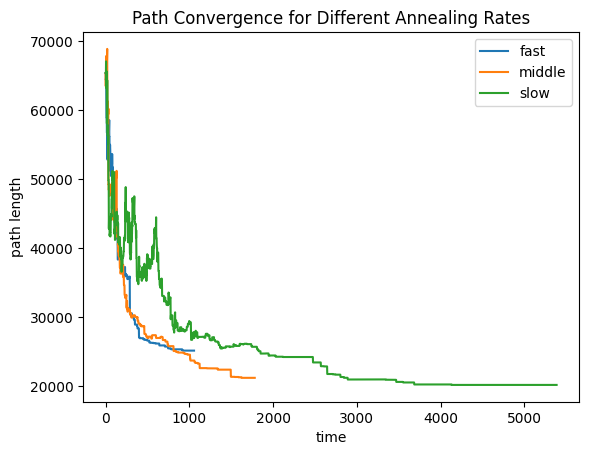

In [8]:
plt.plot(fast_times, fast_all_paths, label='fast')
plt.plot(middle_times, middle_all_paths, label='middle')
plt.plot(slow_times, slow_all_paths, label='slow')

plt.title('Path Convergence for Different Annealing Rates')
plt.xlabel('time')
plt.ylabel('path length')
plt.legend()
plt.show()

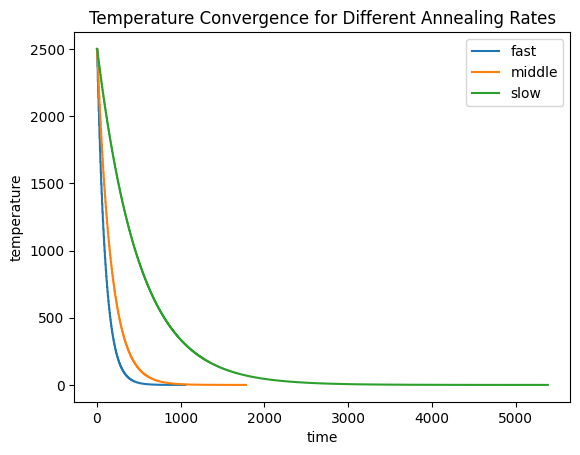

In [9]:
plt.plot(fast_times, fast_temprs, label='fast')
plt.plot(middle_times, middle_temprs, label='middle')
plt.plot(slow_times, slow_temprs, label='slow')

plt.title('Temperature Convergence for Different Annealing Rates')
plt.xlabel('time')
plt.ylabel('temperature')
plt.legend()
plt.show()

## 5. Produce visualization of optimization process 

In [11]:
# data for visualization
v_optimal_cities, v_current_path, v_all_cities, v_all_paths, v_times, v_temprs = simulated_annealing(cities, 2500, 0.98)

In [12]:
# get coordinates of Russia outline
with open('/content/sample_data/russia.json') as f:
    russia_json = json.load(f)
russia_outline = russia_json[0]["geojson"]["coordinates"]

In [60]:
# source: https://medium.com/nuances-of-programming/анимации-с-matplotlib-3fcc634ce7bb
fig = plt.figure(figsize=(20, 12))
ax = plt.axes(xlim=(20, 190), ylim=(40, 80))
line, = ax.plot([], [], lw=2)

# initialization function
# creates plot with Russia outline and cities names
def init():
    # plot Russia outline
    for i in range(len(russia_outline)):
        poly_i = np.array(russia_outline[i])[0]
        plt.plot(poly_i[:, 0], poly_i[:, 1], c='purple')

    # plot cities and their names
    for i in range(v_all_cities[0].shape[0]):
        plt.scatter(v_all_cities[0][i, 2], v_all_cities[0][i, 1])
        plt.annotate(v_all_cities[0][i, 0], (v_all_cities[0][i, 2], v_all_cities[0][i, 1] + 0.3))
    line.set_data([], [])
    return line, 

# animation function plot current path
def animate(i):
    xs = v_all_cities[i * 10][:, 2].copy().tolist()
    xs.append(v_all_cities[i * 10][0, 2])

    ys = v_all_cities[i * 10][:, 1].copy().tolist()
    ys.append(v_all_cities[i * 10][0, 1])
    
    line.set_data(xs, ys)
    return line, 

plt.title('Simulated Annealing for Solving Salesman Problem')  
plt.xlabel("longitude")
plt.ylabel("latitude")

# call animator	function
anim = FuncAnimation(fig, animate, init_func=init, frames=len(v_all_paths) // 20, interval=100) 

# save animation as gif
anim.save('visualization.gif')

<IPython.core.display.Javascript object>